# Priblem 1

In [18]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

## Dataset Ⅳ

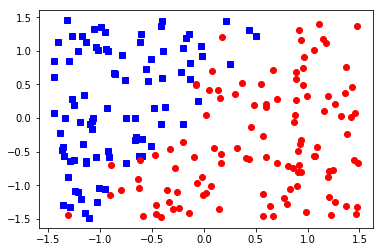

In [19]:
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1

plt.plot(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1], 'bs')
plt.plot(x_d4[y_d4 > 0, 0],  x_d4[y_d4 > 0, 1], 'ro')

#print(x_d4)
#print(y_d4)
#print(x_d4[1,1])
#print(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1])

## 基底クラス

In [20]:
class Sigmoid:
    def __init__(self, dim, lr, lam):
        # 重みの初期化は下記のいずれか(損失の変化が比較できるので，今回はゼロで初期化)
        # self.weight = np.random.randn(dim)
        self.weight = np.zeros(dim)
        self.lr = lr
        self.lam = lam
        self.loss_history = np.zeros(0)

    def sigmoid(self, x, y):
        return 1 / (1 + np.exp(-y * np.dot(self.weight, x)))

    def grad(self, x, y):
        return (self.sigmoid(x, y) - 1.0) * y * x

    def hessian(self, x, y):
        _x = np.array([x])
        _x_t = _x.transpose()
        p = self.sigmoid(x, y)
        # 本当はy^2も掛ける必要があるが，今回の場合は1 or -1なので省略
        return p * (1 - p) * _x * _x_t * y * y
    
    def predict(self, x, y):
        return np.log(self.sigmoid(x, y)**-1) + self.lam * np.linalg.norm(x)
    
    def classifier(self, x):
        return 1 if np.dot(self.weight, x) > 0 else -1

## 最急降下法

In [21]:
class GradientMethod(Sigmoid):
    def __init__(self, dim=4, lr=0.1, lam=0.001):
        super(GradientMethod, self).__init__(dim, lr, lam)

    def train(self, x, y, epochs=10):
        self.loss_history = np.zeros(epochs)
        self.loss_history_2 = np.zeros(epochs)
        for epoch in range(epochs):
            _grad = np.zeros(4)
            _loss = 0.0
            
            for i in range(len(x)):
                _grad += self.grad(x[i], y[i])
                _loss += self.predict(x[i], y[i])
                #print("_loss = {}".format(_loss))
                
            _grad = _grad / len(x) + 2 * self.lam * self.weight
            self.weight -= self.lr * _grad

            _loss = _loss / len(x)
            self.loss_history[epoch] = _loss
            #print("loss = {}".format(_loss)) 
            #print("weight = {}".format(self.weight))

In [22]:
epochs = 500
gm = GradientMethod()
gm.train(x_d4, y_d4, epochs)

## ニュートン法

In [23]:
class NewtonMethod(Sigmoid):
    def __init__(self, dim=4, lr=0.1, lam=0.001):
        super(NewtonMethod, self).__init__(dim, lr, lam)
        self.dim = dim
            
    def train(self, x, y, epochs=10):
        self.loss_history = np.zeros(epochs)
        for epoch in range(epochs):
            _grad = np.zeros(4)
            _hesse = np.zeros((4,4))
            _loss = 0.0
            for i in range(len(x)):
                _grad += self.grad(x[i], y[i])
                _hesse += self.hessian(x[i], y[i])
                _loss += self.predict(x[i], y[i])
            _grad = _grad / len(x) + 2 * self.lam * self.weight
            _hesse = _hesse / len(x) + 2 * self.lam * np.identity(self.dim)
            self.weight -= (self.lr * np.matrix(_grad) * np.linalg.inv(_hesse)).A1
            #self.weight -= (np.matrix(_grad) * np.linalg.inv(_hesse)).A1

            _loss = _loss / len(x)
            self.loss_history[epoch] = _loss            
            #print("loss = {}".format(_loss)) 

In [24]:
nm = NewtonMethod()
nm.train(x_d4, y_d4, epochs)

## 確認用
学習データをそのままpredictしているので，汎化性を確認するものでないことに注意

あくまで，学習データにフィットしているか確認するもの

In [25]:
def train_data_accuracy(model, x, y, debug=False):
    count = 0
    for i in range(len(x)):
        if debug:
            print(model.classifier(x[i]), y[i])
        count = count + 1 if model.classifier(x[i]) == y[i] else count
    print(count / len(x))
    
train_data_accuracy(gm, x_d4, y_d4)
train_data_accuracy(nm, x_d4, y_d4)

0.92
0.92


## J(w)の変化の比較

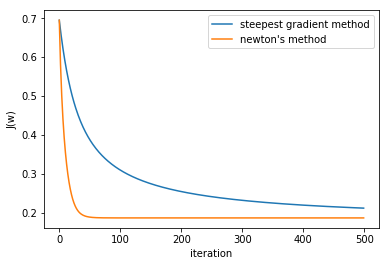

In [26]:
x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w)")
plt.plot(x_axis, gm.loss_history, label="steepest gradient method")
plt.plot(x_axis, nm.loss_history, label="newton's method")
plt.legend()
plt.show()

## J(w) - J(w^)の変化の比較

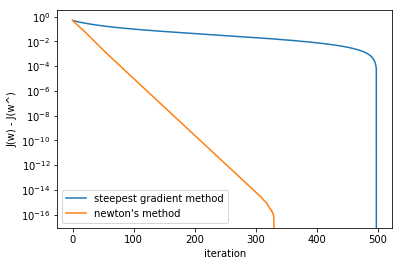

In [27]:
#epochs = 500
gm_loss_history_2 = np.zeros(epochs)
nm_loss_history_2 = np.zeros(epochs)

#print(gm.loss_history[epochs - 1])

for epoch in range(epochs):
    gm_loss_history_2[epoch] = gm.loss_history[epoch] - gm.loss_history[epochs - 1]
    nm_loss_history_2[epoch] = nm.loss_history[epoch] - nm.loss_history[epochs - 1]
    

x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w) - J(w^)")
plt.semilogy(x_axis, gm_loss_history_2, label="steepest gradient method")
plt.semilogy(x_axis, nm_loss_history_2, label="newton's method")
#plt.plot(x_axis, gm_loss_history_2, label="steepest gradient method")
#plt.plot(x_axis, nm_loss_history_2, label="newton's method")
#plt.yscale('log')
plt.legend()
plt.show()

## DatasetⅤ

In [28]:
# dataset 5
n = 200
x_d5 = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_d5 = np.argmax(np.dot(np.hstack([x_d5[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

#plt.plot(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1], 'bs')
#plt.plot(x_d4[y_d4 > 0, 0],  x_d4[y_d4 > 0, 1], 'ro')

#print(x_d5)
#print(y_d5)
#print(x_d5[1,1])
#print(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1])

## 最急降下法

In [29]:
epochs = 200
gm = GradientMethod()
gm.train(x_d5, y_d5, epochs)

## ニュートン法

In [30]:
nm = NewtonMethod()
nm.train(x_d5, y_d5, epochs)

## J(w)の変化の比較

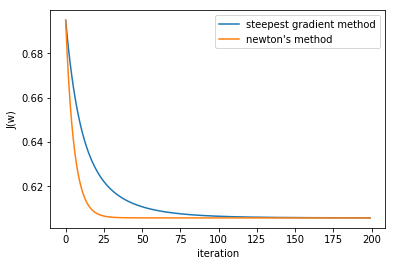

In [31]:
x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w)")
plt.plot(x_axis, gm.loss_history, label="steepest gradient method")
plt.plot(x_axis, nm.loss_history, label="newton's method")
plt.legend()
plt.show()

## J(w) - J(w^)の変化の比較

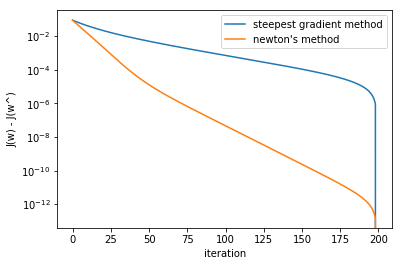

In [32]:
#epochs = 200
gm_loss_history_3 = np.zeros(epochs)
nm_loss_history_3 = np.zeros(epochs)

#print(gm.loss_history[epochs - 1])

for epoch in range(epochs):
    gm_loss_history_3[epoch] = gm.loss_history[epoch] - gm.loss_history[epochs - 1]
    nm_loss_history_3[epoch] = nm.loss_history[epoch] - nm.loss_history[epochs - 1]
    

x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w) - J(w^)")
plt.semilogy(x_axis, gm_loss_history_3, label="steepest gradient method")
plt.semilogy(x_axis, nm_loss_history_3, label="newton's method")
#plt.plot(x_axis, gm_loss_history_2, label="steepest gradient method")
#plt.plot(x_axis, nm_loss_history_2, label="newton's method")
#plt.yscale('log')
plt.legend()
plt.show()